# Autoencoding our variables

### Import the python torch and tensorflow modules and make sure we're ready to rock and roll

In [1]:
import os
import sys
import torch

import tensorflow as tf
from tensorflow.keras import layers, models

if not torch.cuda.is_available():
    print("FATAL: Please run this notebook in an environment with CUDA available", file=sys.stderr)
else:
    print("Lets go GPU", file=sys.stderr)

2025-10-16 15:26:09.389141: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Lets go GPU


## Import the libraries.

This is my standard import.

In [2]:
import os
import sys
from socket import gethostname

hostname = gethostname()

if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False
from cf_analysis_lib.load_libraries import *
import cf_analysis_lib


## Read the data

In [3]:
sequence_type = "MGI"
datadir = '..'
sslevel = 'subsystems_norm_ss.tsv.gz'
taxa = "family"

df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel='subsystems_norm_ss.tsv.gz', taxa="family")

Using ../MGI/FunctionalAnalysis/subsystems/MGI_subsystems_norm_ss.tsv.gz for the subsystems


In [4]:
# read the MAGs
bin_df = cf_analysis_lib.read_bin_coverage(normalization='RPKM', datadir=datadir, verbose=True)
print(f"The MAG df has shape: {bin_df.shape}")
df = df.merge(bin_df, left_index=True, right_index=True, how='inner')
print(f"The combined data frame has shape {df.shape}")

The MAG df has shape: (127, 3214)
The combined data frame has shape (127, 4726)


Dropping ['mag_3149'] from the bin coverage data as they have zero variance


## Somewhere to save the outputs!

In [5]:
outdir = 'cluster_gbrfs_mags'
os.makedirs(outdir, exist_ok=True)

### Split the data

In [6]:
training_data, validate_data = train_test_split(df, test_size=0.2, random_state=42)
print(f"Train: {training_data.shape}")
print(f"Test: {validate_data.shape}")

Train: (101, 4726)
Test: (26, 4726)


## Develop the autoencoder

Because an autoencoder reconstructs its inputs, the “labels” (y) are the same as the features (X), so `x=training_data`, and `y=training_data`.

2025-10-16 15:26:19.627342: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 333 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:c1:00.0, compute capability: 7.0


Epoch 1/200


2025-10-16 15:26:21.899849: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x555588306d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-16 15:26:21.899906: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2025-10-16 15:26:21.906538: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-16 15:26:21.928031: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2025-10-16 15:26:22.068080: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 [==============================] - 4s 53ms/step - loss: 32728194.0000 - val_loss: 31187534.0000
Epoch 2/200
7/7 [==============================] - 0s 12ms/step - loss: 24539882.0000 - val_loss: 17935448.0000
Epoch 3/200
7/7 [==============================] - 0s 12ms/step - loss: 16893224.0000 - val_loss: 13674383.0000
Epoch 4/200
7/7 [==============================] - 0s 12ms/step - loss: 14548016.0000 - val_loss: 11916281.0000
Epoch 5/200
7/7 [==============================] - 0s 12ms/step - loss: 13957594.0000 - val_loss: 11457423.0000
Epoch 6/200
7/7 [==============================] - 0s 12ms/step - loss: 13329546.0000 - val_loss: 10927303.0000
Epoch 7/200
7/7 [==============================] - 0s 12ms/step - loss: 12685430.0000 - val_loss: 10378921.0000
Epoch 8/200
7/7 [==============================] - 0s 12ms/step - loss: 11594757.0000 - val_loss: 9192949.0000
Epoch 9/200
7/7 [==============================] - 0s 12ms/step - loss: 10116988.0000 - val_loss: 7749858.5000
Epoch 

INFO:tensorflow:Assets written to: cluster_gbrfs_mags/autoencoder_model/assets


INFO:tensorflow:Assets written to: cluster_gbrfs_mags/encoder_model/assets


INFO:tensorflow:Assets written to: cluster_gbrfs_mags/encoder_model/assets


INFO:tensorflow:Assets written to: cluster_gbrfs_mags/decoder_model/assets


INFO:tensorflow:Assets written to: cluster_gbrfs_mags/decoder_model/assets


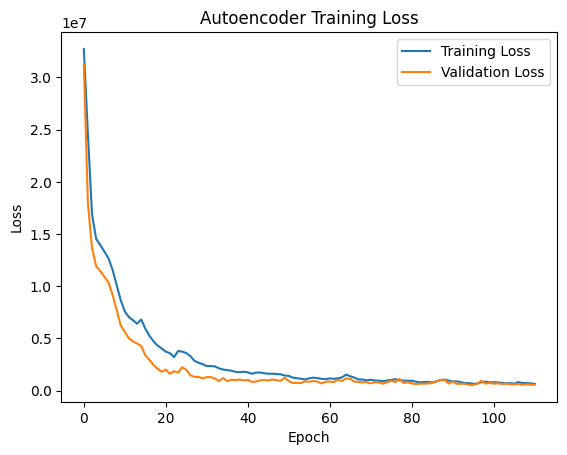

4/4 [==============================] - 0s 3ms/step


In [7]:
# do we have a saved model?

if os.path.exists(os.path.join(outdir, "autoencoder_model")):
    print(f"Loading the autoencoder from disk. Remove {os.path.join(outdir, 'autoencoder_model')} to recreate the model", file=sys.stderr)
    autoencoder = models.load_model(os.path.join(outdir, "autoencoder_model"), compile=False)
    autoencoder.compile(optimizer='adam', loss='mse')
    encoder = models.load_model(os.path.join(outdir, "encoder_model"), compile=False)
    decoder = models.load_model(os.path.join(outdir, "decoder_model"), compile=False)
    encoder.compile()
    decoder.compile()
else:
    # 1) Define network parameters
    input_dim = len(df.columns)
    latent_dim = 50  # tweak this
    
    # 2) Build the encoder
    encoder_input = tf.keras.Input(shape=(input_dim,))
    x = layers.Dense(512, activation='relu')(encoder_input)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    encoder_output = layers.Dense(latent_dim, activation='linear')(x)
    
    # 3) Build the decoder
    decoder_input = layers.Input(shape=(latent_dim,))
    y = layers.Dense(128, activation='relu')(decoder_input)
    y = layers.Dense(512, activation='relu')(y)
    decoder_output = layers.Dense(input_dim, activation='linear')(y)
    
    # 4) Create autoencoder
    encoder = tf.keras.Model(encoder_input, encoder_output, name="encoder")
    decoder = tf.keras.Model(decoder_input, decoder_output, name="decoder")
    
    autoencoder_input = tf.keras.Input(shape=(input_dim,))
    encoded = encoder(autoencoder_input)
    decoded = decoder(encoded)
    
    autoencoder = tf.keras.Model(autoencoder_input, decoded, name="autoencoder")
    
    # 5) Compile & train
    autoencoder.compile(optimizer='adam', loss='mse')
    result = autoencoder.fit(
        x=training_data,
        y=training_data,
        epochs=200,
        batch_size=16,
        validation_data=(validate_data, validate_data),
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)]
    )


    autoencoder.save(os.path.join(outdir, "autoencoder_model"), overwrite=True)
    encoder.save(os.path.join(outdir, "encoder_model"), overwrite=True)
    decoder.save(os.path.join(outdir, "decoder_model"), overwrite=True)

    # Plot training & validation loss
    plt.plot(result.history['loss'], label='Training Loss')
    plt.plot(result.history['val_loss'], label='Validation Loss')
    
    plt.title('Autoencoder Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
# 6) Extract low-dimensional features
train_latent = encoder.predict(training_data)
val_latent = encoder.predict(validate_data)
all_data = encoder.predict(df)

# Predict which original features cluster

Looking at the correlation to the encoded data

We compute Correlation Between Each Original Feature and Each Latent Dimension

In [8]:
num_features = df.shape[1]  # 1512
num_latent_dims = all_data.shape[1]       # 50 - the number of output layers

corr_matrix = pd.DataFrame(index=df.columns, columns=[f"LD_{i}" for i in range(num_latent_dims)])

for i in range(num_features):
    for j in range(num_latent_dims):
        try:
            corr = np.corrcoef(df.iloc[:, i], all_data[:, j])[0, 1]
            corr_matrix.iloc[i, j] = corr
        except:
            print(f"Error predicting {i} and {j}", file=sys.stderr)
            break

corr_matrix = corr_matrix.astype(float)
corr_matrix.head()

,LD_0,LD_1,LD_2,LD_3,LD_4,LD_5,LD_6,LD_7,LD_8,LD_9,...,LD_40,LD_41,LD_42,LD_43,LD_44,LD_45,LD_46,LD_47,LD_48,LD_49
"2,3-diacetamido-2,3-dideoxy-d-mannuronic acid",-0.139790,0.077047,-0.126179,0.267432,-0.152435,-0.231164,-0.418514,0.086832,-0.248288,0.453301,...,0.031046,-0.086989,-0.303837,-0.074958,-0.007812,0.238644,0.271189,0.034544,0.164343,0.168716
2-O-alpha-mannosyl-D-glycerate utilization,0.420139,0.195288,0.332768,0.429995,-0.408453,0.570893,0.129253,-0.665639,-0.182132,-0.066236,...,0.470858,0.384373,0.581146,-0.657337,-0.131413,0.268906,-0.139619,0.049067,-0.572060,-0.164355
2-aminophenol Metabolism,-0.233257,0.375427,-0.108271,0.472345,-0.320693,-0.002995,-0.487118,-0.123143,-0.118712,0.066847,...,0.275075,0.020777,-0.081028,-0.208668,0.243682,0.387364,0.058169,-0.059993,-0.133769,-0.048809
2-ketoacid oxidoreductases disambiguation,-0.368917,0.067943,-0.238158,-0.100150,0.244254,-0.379581,-0.372837,0.328400,-0.189063,0.381546,...,0.067754,0.136187,-0.478515,0.190507,0.253229,-0.228923,-0.056743,0.548079,0.209527,0.635214
2-oxoglutarate dehydrogenase,-0.556054,-0.004514,-0.447836,-0.158494,0.312313,-0.087216,-0.274219,0.464474,0.425773,-0.252509,...,-0.021636,-0.346246,-0.566788,0.439886,0.310029,0.295102,0.092628,-0.094633,0.245072,-0.095572


## Cluster the original input data and the latent models using k-means

Here, we take the correlation matrix from the ANN - correlating which of our 1512 features map to the same output nodes from the ANN and we build clusters using k-means hierarchical clustering.

The 150 clusters is somewhat random - it is ~10% of the input data and it only gives 3 singletons, and breaks the Pseudomonas cluster down quite a bit.

In [9]:
if os.path.exists(os.path.join(outdir, 'clusters.json')):
    with open(os.path.join(outdir, 'clusters.json'), 'r') as file:
        data = json.load(file)
    tmpjsondf = pd.DataFrame(list(data.items()), columns=['Cluster', 'Feature'])
    cluster_assignments = tmpjsondf.explode('Feature').reset_index(drop=True)
    cluster_assignments['Cluster'] = cluster_assignments['Cluster'].astype(int)
else:
    # Calculate linkage on the rows (i.e., the features)
    Z = linkage(corr_matrix, method='ward', metric='euclidean')
    
    k = 150  # more clusters, smaller groups!
    clusters = fcluster(Z, k, criterion='maxclust')  # Each feature gets a cluster ID [1..k]
    
    # create a df with the cluster assignments
    cluster_assignments = pd.DataFrame({
        "Feature": corr_matrix.index,  # the feature names
        "Cluster": clusters
    })
    cluster_assignments.sort_values("Cluster", inplace=True)
    grouped = cluster_assignments.groupby("Cluster")
    by_cluster = {str(cluster_id): group["Feature"].tolist() for cluster_id, group in grouped}
    with open(os.path.join(outdir, 'clusters.json'), 'w') as json_file:
        json.dump(by_cluster, json_file, indent=4)


### Print out the clusters that contain _Pseudomonas_ subsystems

In [10]:
interesting_cluster = None
interesting_cluster_count = 0
grouped = cluster_assignments.groupby("Cluster")
for cluster_id, group in grouped:
    if group['Feature'].str.contains('Pseudomonas').any():
        if group['Feature'].str.contains('Pseudomonas').sum() > interesting_cluster_count:
            interesting_cluster_count = group['Feature'].str.contains('Pseudomonas').sum()
            interesting_cluster = cluster_id
        print(f"--- Cluster {cluster_id} : Length {group['Feature'].shape[0]} ---")
        print(group["Feature"].tolist())
        print()
print(f"Interesting cluster is Cluster {interesting_cluster}")

--- Cluster 138 : Length 64 ---
['Taurine and alkanesulfonate utilization as sulfur sources', 'Beta-lactamases Ambler class D', 'CMP-pseudaminic acid synthesis', 'mag_3096', 'Mycobacterial FadE proteins Acyl-CoA dehydrogenase', 'Extracellular matrix proteins (PEL) involved in glucose-rich biofilm formation in Pseudomonas', 'Biogenesis of cbb3-type cytochrome c oxidases', 'tRNA modification, 5-oxyacetyl uridine (cmo5U34)', 'EnvZ and OmpR regulon', 'Mycobacterial FadD proteins (fatty acid CoA- and AMP- ligases)', 'Sulfur transfer pathway CsdAEL', 'Mycobacterial gene cluster associated with resistance against FAS-II antibiotics', 'MexXY System of Pseudomonas aeruginosa', 'Stress proteins YciF, YciE', 'Carnitine metabolism and transport', 'Coenzyme PQQ synthesis', 'Heme and heme d1 biosynthesis from siroheme', 'Chromobacteriaceae', 'Iron siderophore sensor & receptor system', 'Cholera toxin', 'mag_118', 'Siderophore Pyoverdine', 'Trans-envelope signaling system VreARI in Pseudomonas', 'Gen

### How many singletons are there in the groups?

In [11]:
singletons = 0
for cluster_id, group in grouped:
    if group['Feature'].shape[0] == 1:
        singletons+=1
print(f"There are {singletons} single clusters")

There are 0 single clusters


## Write all the clusters out

This is so we can use them again!

In [12]:
grouped = cluster_assignments.groupby("Cluster")
with open(os.path.join(outdir, 'cluster_features.txt'), 'w') as out:
    for cluster_id, group in grouped:
        print(f"--- Cluster {cluster_id} : Length {group['Feature'].shape[0]} ---", file=out)
        print(group["Feature"].tolist(), file=out)
        print(file=out)
cluster_assignments.to_csv(os.path.join(outdir, 'clusters.tsv'), sep="\t", index=False)

In [13]:
intcols = ['Pseudomonas Culture', 'N12M_Pseudomonas aeruginosa', 'N12M_mucoid', 'N12M_non_mucoid']
df_clust = df[cluster_assignments.loc[cluster_assignments["Cluster"] == interesting_cluster, "Feature"]]
merged_df_clust = df_clust.join(metadata[intcols])
merged_df_clust.to_csv(os.path.join(outdir, 'Pseudomonas_cluster.tsv'), sep="\t")

### Cluster correlations

Now we have clusters, lets take one cluster and see how it correlates to itself.

Note that the ANN has learnt things that both positively and negatively correlate.

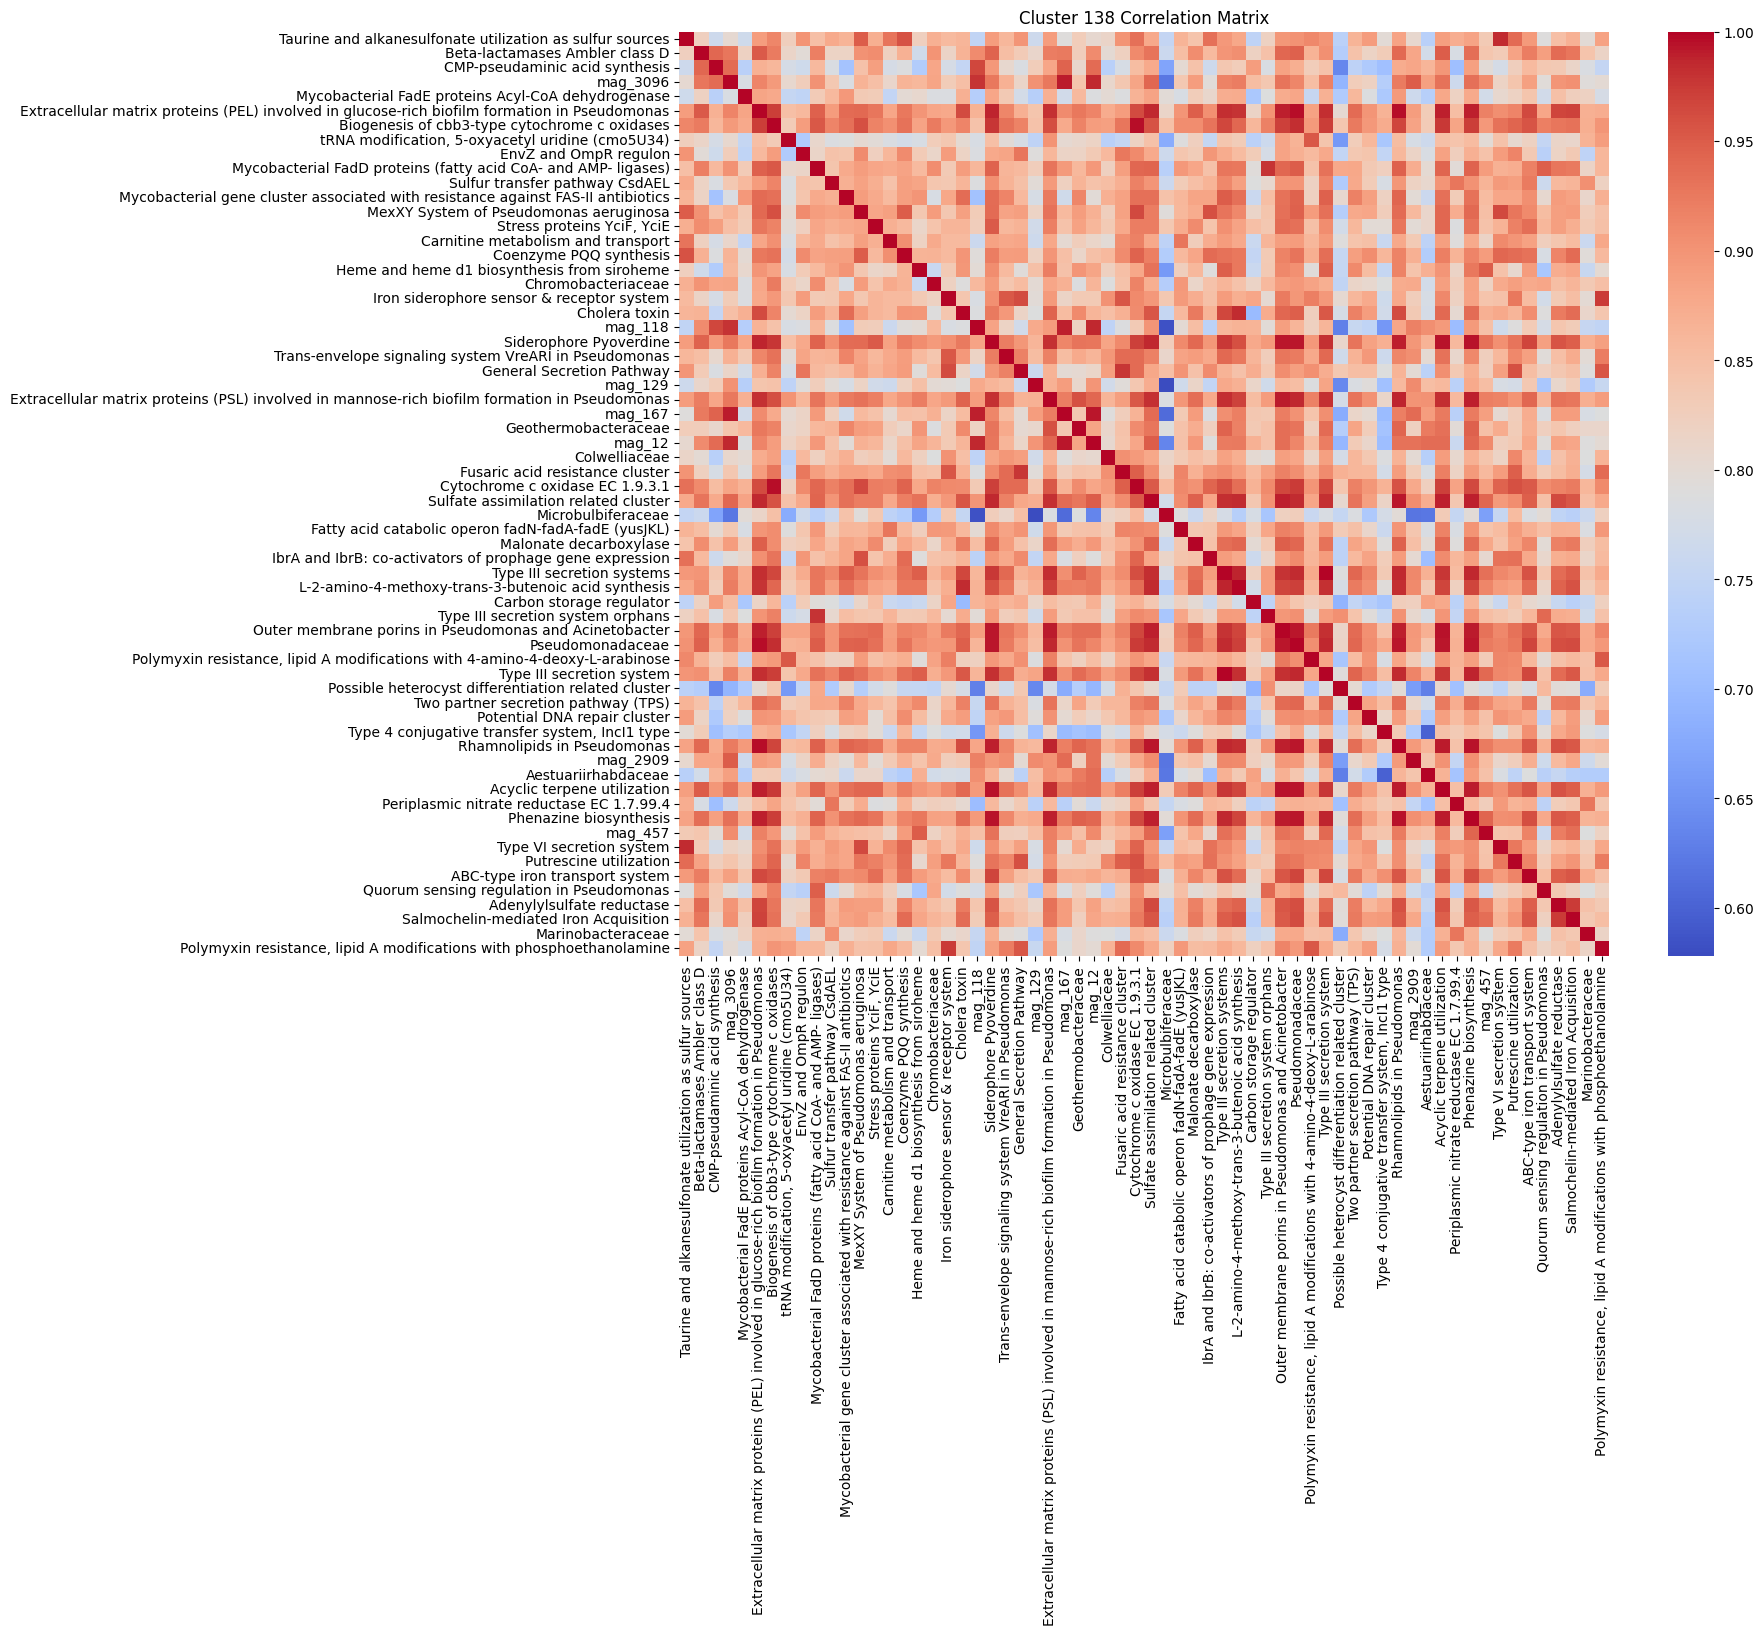

In [14]:
df_clust = df[cluster_assignments.loc[cluster_assignments["Cluster"] == interesting_cluster, "Feature"]]
df_clust_corr = df_clust.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(df_clust_corr, annot=False, cmap='coolwarm')
plt.title(f'Cluster {interesting_cluster} Correlation Matrix')
plt.show()

## Creating a new df with principal components of the data

Here, we make a new data frame that has the PC1 for each _cluster_. This doesn't matter if the cluster has positive/negative correlations because we are looking at the PC.

We can use this matrix in our machine learning approaches like gradient boosted random forest!

In [15]:
if os.path.exists(os.path.join(outdir, 'pc_df.tsv')):
    pc_df = pd.read_csv(os.path.join(outdir, 'pc_df.tsv'), sep="\t", index_col=0)
else:
    pca = PCA(n_components=1)
    pc_df = pd.DataFrame(index=df.index, columns=[f"Cluster {x+1}" for x in range(len(cluster_assignments.groupby("Cluster").size()))])
    for cluster_id, group in grouped:
        df_clust = df[cluster_assignments.loc[cluster_assignments["Cluster"] == cluster_id, "Feature"]]
        pc_df[f"Cluster {cluster_id}"] = pca.fit_transform(df_clust).ravel()
    pc_df.to_csv(os.path.join(outdir, 'pc_df.tsv'), sep="\t")
pc_df

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,...,Cluster 141,Cluster 142,Cluster 143,Cluster 144,Cluster 145,Cluster 146,Cluster 147,Cluster 148,Cluster 149,Cluster 150
1068841_20180306_S,263.158056,438.373541,1334.751455,204.231323,1343.068071,4343.682830,97601.004641,2609.652825,1775.503488,1825.493547,...,-110.314470,-177.945775,-1296.327935,-1262.987883,-24373.250816,-736.688522,-717.911430,-993.917117,-1238.132453,-1590.352460
1447437_20171212_S,2658.745438,4425.280079,1480.237427,370.174637,1879.147673,-183.339759,-53481.172573,-2048.864186,-1360.385766,-3074.432724,...,-644.861394,-126.542810,-844.792793,330.883603,253140.289273,5884.359436,2678.900377,10021.987809,3091.300475,618.164237
1128691_20171206_S,-627.063918,-2974.425323,-3924.153971,-2291.614011,-6557.982920,-1995.275970,-195356.134462,-11883.849598,-3770.087222,-7777.162530,...,4280.847028,1527.593742,17973.460142,7103.694052,-21120.613720,-1913.393261,836.388071,8776.647747,9541.624048,5004.868582
1128691_20171218_S,-52.541366,-1880.716014,-3374.506576,-1889.768318,-5247.923312,-1641.493937,-173496.042373,-9400.540211,-3737.764496,-6821.566689,...,3435.175302,1461.843174,14497.941967,6182.603709,-2545.894977,-967.083636,511.047029,8410.946400,8540.572429,4106.866742
1128691_20180116_S,-1064.576406,-3395.129130,-4511.412645,-2361.691534,-7098.685627,-2038.956795,-215990.744673,-13337.052100,-4237.999697,-7990.858318,...,4049.513565,1832.467981,18261.593904,7143.105179,-23856.028556,-2140.765038,631.837525,8432.787242,9747.495585,5061.033270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895293_20180502_S,422.598709,-396.228952,-671.192287,-2049.083965,812.793695,-1908.723687,90340.692385,-488.469827,262.649547,-1250.545113,...,-928.274770,-132.961084,-820.959345,-270.478601,-25120.937760,-1148.012201,-366.743386,-1829.601403,-813.129084,-1066.550000
896213_20180427_S,-960.889635,-1007.585889,-1003.645570,163.329078,-1262.474395,1950.210928,-42548.981934,-2477.900338,-39.752455,4213.174975,...,200.674410,-101.688344,-357.392166,-241.694713,-24328.591201,336.458125,-2010.958274,4428.868084,-721.313683,-915.808999
913873_20180417_S,-673.484878,-275.311313,-371.254996,-291.726476,-499.790655,3576.055055,-1813.946979,1434.963743,-499.604033,4897.076137,...,-1048.361995,56.529879,-559.555618,287.972442,-18521.524275,931.912404,-249.766973,6856.939012,-941.662645,271.619970
980574_20180403_S,-574.011867,-95.560240,-483.783219,-407.757108,-36.948156,-784.552033,-2495.746358,-208.471857,-583.516419,-2754.431318,...,-27.684839,-187.210919,-1224.034919,-724.050524,-24508.432735,-875.844692,455.337871,-2380.748074,-1388.773474,-714.446284


### Plot a PCA

We just plot the PCA of one component to see what it looks like. This is our `interesting component`, of course, the one with all the Pseudomonodaceae

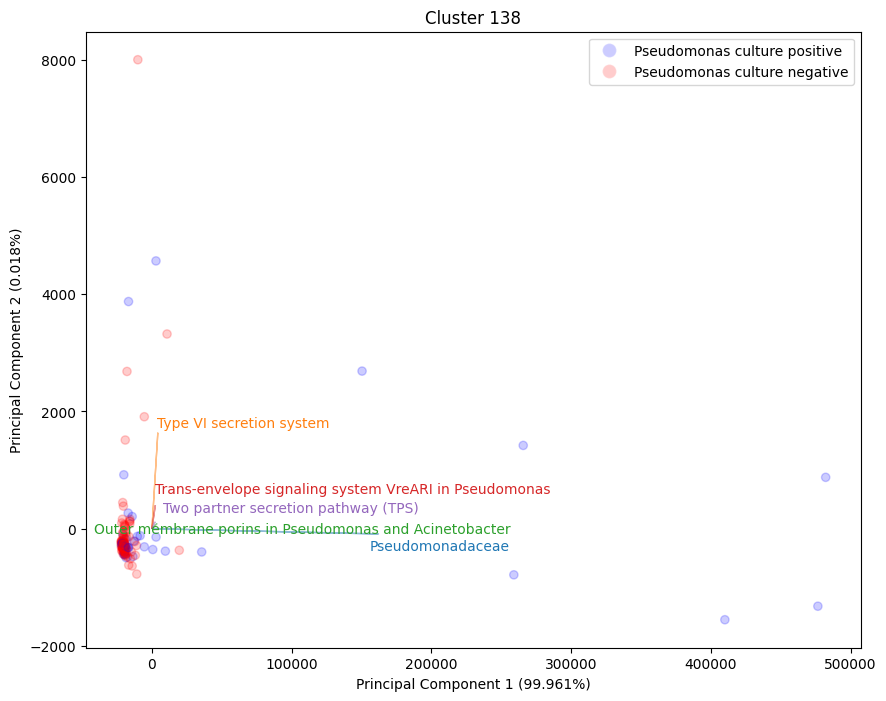

In [16]:
pca = PCA(n_components=2)

intcol = 'Pseudomonas Culture'
df_clust = df[cluster_assignments.loc[cluster_assignments["Cluster"] == interesting_cluster, "Feature"]]
merged_df_clust = df_clust.join(metadata[[intcol]])

pca_result = pca.fit_transform(df_clust)
pca_df = pd.DataFrame(data=pca_result, index=df.index, columns=['PC1', 'PC2'])

# Get loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(loadings, index=df_clust.columns, columns=['PC1', 'PC2'])

# Create a DataFrame for top loadings
top_loadings_df = loadings_df.loc[loadings_df['PC1'].abs().sort_values(ascending=False).index]
top_loadings_df.head()

explained_variance = pca.explained_variance_ratio_ * 100
pc1_variance = explained_variance[0]
pc2_variance = explained_variance[1]

colours = np.where(merged_df_clust['Pseudomonas Culture'] == 1, 'blue', 'red')

# Plot the PCA results
plt.figure(figsize=(10, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.2, c=colours)
plt.title(f"Cluster {interesting_cluster}")
plt.xlabel(f'Principal Component 1 ({pc1_variance:.3f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance:.3f}%)')

# add the loadings ... we only plot maxloadings here
maxloadings = 5
if len(loadings) < maxloadings:
    maxloadings = len(loadings)

plotscaler = 2
texts = []
colour_cycle = cycle(mcolors.TABLEAU_COLORS)
found_pseudomonas = False
for i in range(maxloadings):
    c = next(colour_cycle)
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, 
              color=c, alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[i], color=c))

adjust_text(texts)


# Add a legend
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture positive', 
                         markerfacecolor='blue', alpha=0.2, markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture negative', 
                        markerfacecolor='red', alpha=0.2, markersize=10)


plt.legend(handles=[blue_patch, red_patch])


# Show the plot
plt.show()

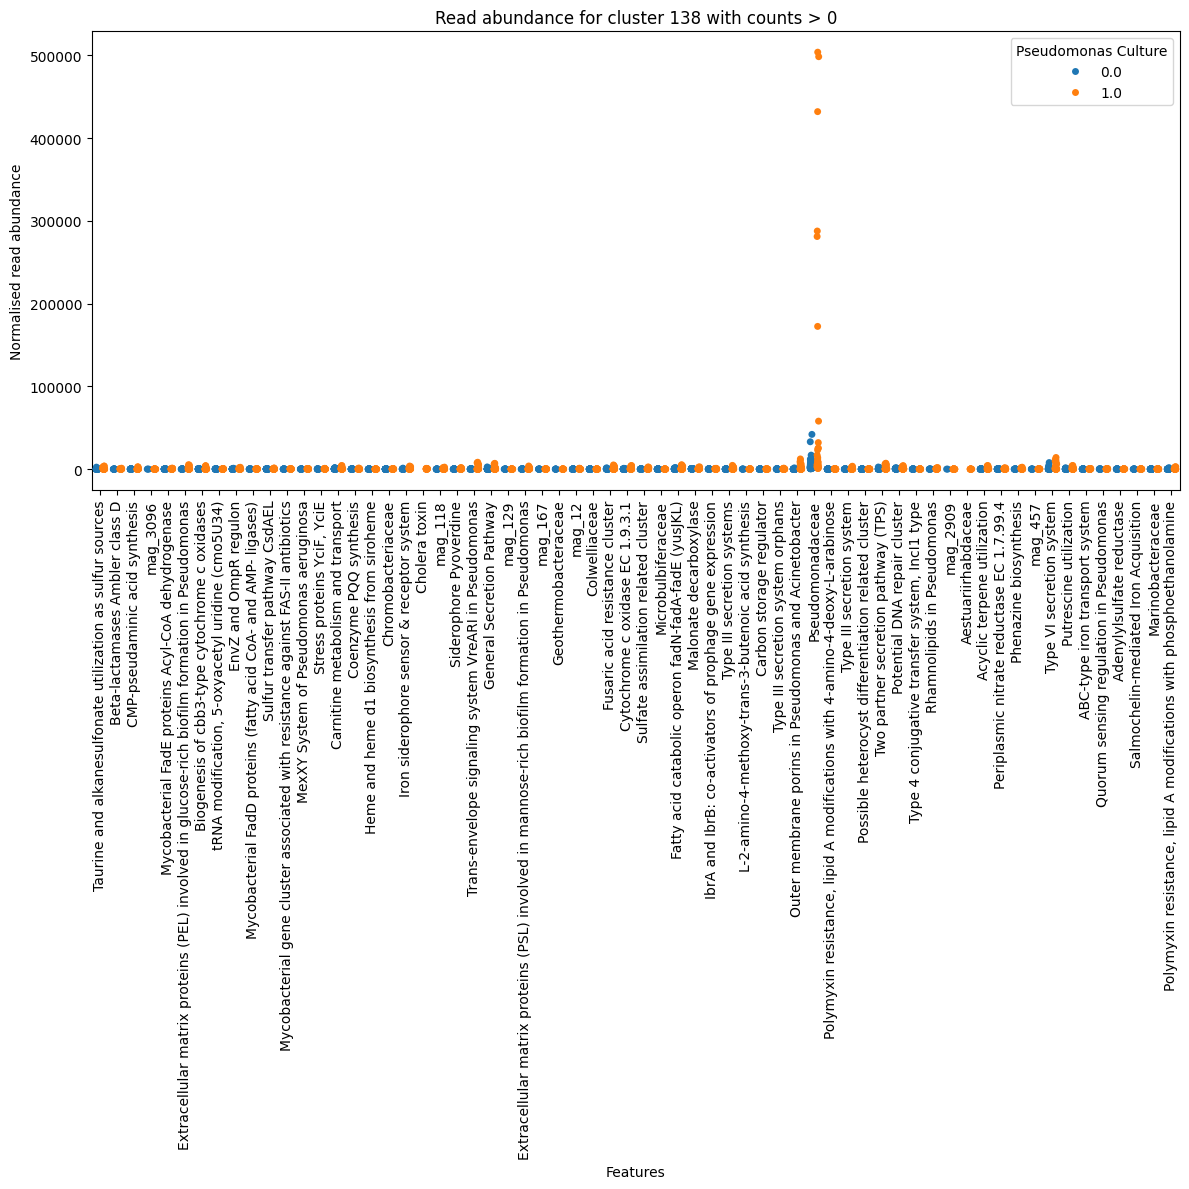

In [17]:
df_clust = df[cluster_assignments.loc[cluster_assignments["Cluster"] == interesting_cluster, "Feature"]]
merged_df_clust = df_clust.join(metadata[[intcol]])
df_clust_m = merged_df_clust.melt(id_vars=intcol, var_name='Features', value_name='Normalised read abundance')
df_clust_m = df_clust_m[df_clust_m['Normalised read abundance'] > 0]
plt.figure(figsize=(12, 12))
sns.stripplot(data=df_clust_m, x='Features', y='Normalised read abundance', hue=intcol, dodge=True, jitter=True)
plt.xticks(rotation=90)
# plt.ylim(0, 10000)
plt.title(f"Read abundance for cluster {interesting_cluster} with counts > 0")
plt.tight_layout()
plt.show()

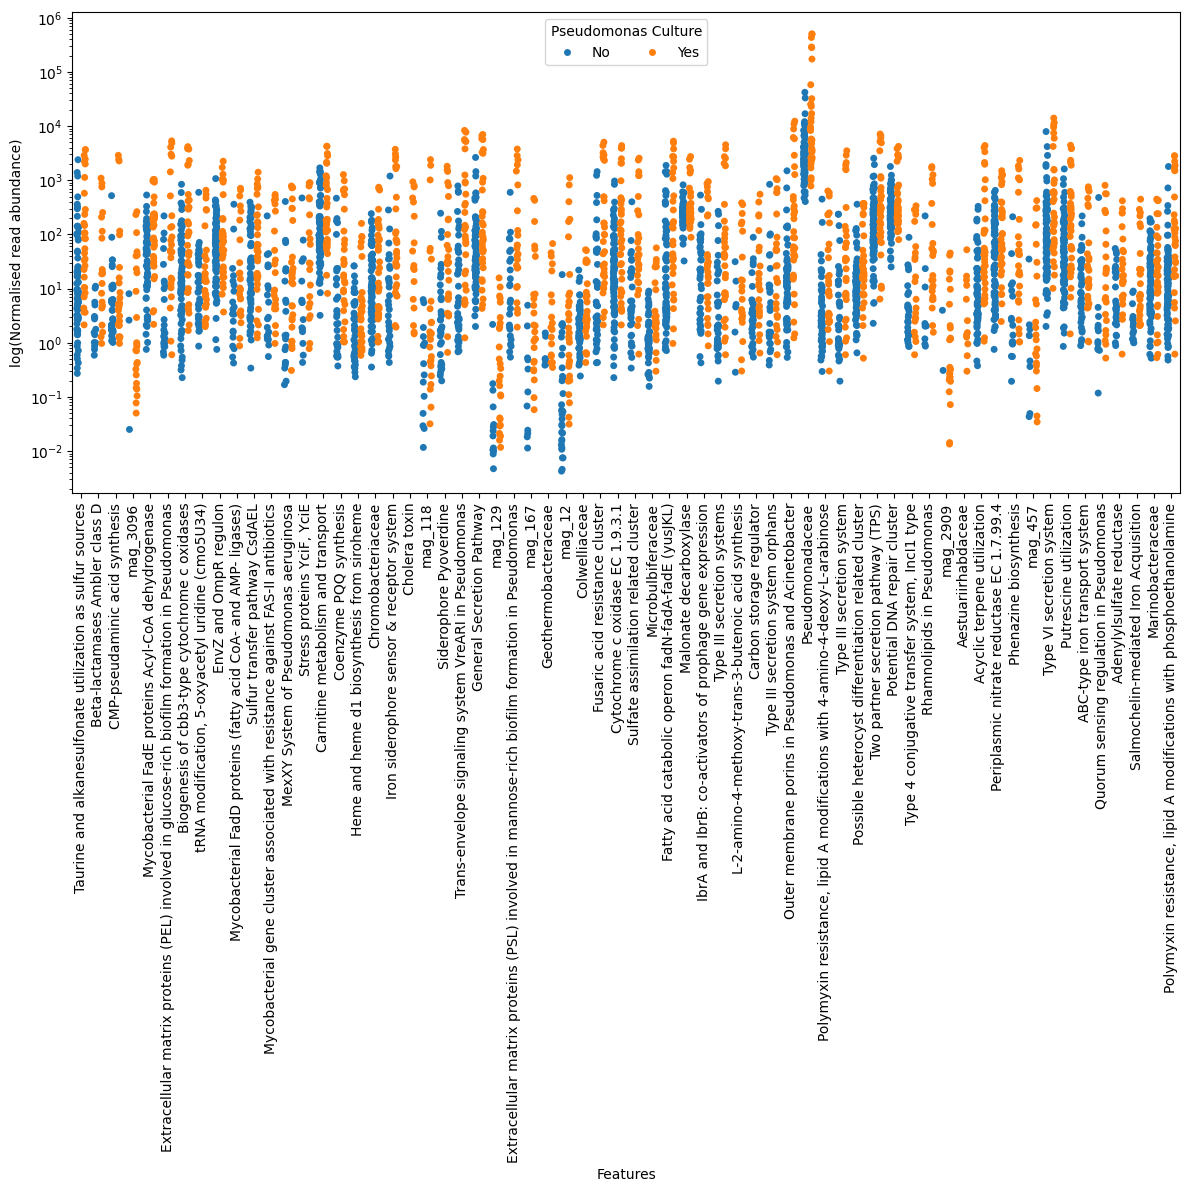

In [18]:
# set up our titles and the filename
intcol_title = replace_index.sub('', intcol)
intcol_filename = intcol.replace(" ", "_")
intcol_filename = replace_nonword.sub('', intcol_filename)
df_clust = df[cluster_assignments.loc[cluster_assignments["Cluster"] == interesting_cluster, "Feature"]]
merged_df_clust = df_clust.join(metadata[[intcol]])
df_clust_m = merged_df_clust.melt(id_vars=intcol, var_name='Features', value_name='Normalised read abundance')
df_clust_m = df_clust_m[df_clust_m['Normalised read abundance'] > 0]
plt.figure(figsize=(12, 12))
g = sns.stripplot(data=df_clust_m, x='Features', y='Normalised read abundance', hue=intcol, dodge=True, jitter=True)
g.set(yscale="log")
g.set_ylabel('log(Normalised read abundance)')
custom_labels = {0: 'No', 1: 'Yes'}
handles, labels = g.get_legend_handles_labels()  # Get one set of handles and labels
updated_labels = [custom_labels[float(label)] for label in labels]
g.get_legend().remove()
g.legend(handles, updated_labels, loc='upper center', ncol=2, title=intcol_title)
plt.xticks(rotation=90)
# plt.ylim(0, 10000)
#plt.title(f"Read abundance for cluster {interesting_cluster}")

plt.tight_layout()
plt.savefig('final_images/cluster31_read_abundance.png')
plt.show()

# GBRF

This code is directly from the GBRF page, but we are using pc_df instead of df, and we're going to predict `Pseudomonas culture`

When we run this multiple times, we get the same answer! Now we only need to run the GBRF once per metadata column

# Run the GBRF for every metadata sample

This code is taken from the gradient_boosting.py script with some minor changes, but runs the GBRF once per sample.

In [19]:
# ignore adjustText warnings in this block
warnings.filterwarnings("ignore", category=UserWarning, module='adjustText')

replace_index = re.compile(r'^\d+\s+')
replace_nonword = re.compile(r'\W+')

resultsfile = open(os.path.join(outdir, 'gbrf_results.txt'), 'w')
print(f"Predictor\tFeature\tImportance", file=resultsfile)

skip_columns = {'minion', 'MGI', 'pwCF_ID', 'Sample_Type', 'Corr', 'CF gene 1', 'CS_NTM_(Smear negative)', 'CS_Aspergillus niger', 'CS_Aspergillus terreus',
                'CS_Scedosporium apiospermum', 'O_Scedosporium apiospermum', 'O_Trichosporon mycotoxinivorans', '3 Aztreonam_IV',
                'DNA_extraction_ conc', 'SAGC ULN', 'DNA Conc. (ng/ul)',
                'Index I7', 'Index I5', 'Mean_Size_BP', 'Total Clusters Passing Filter (Million)'}

n_estimators=1000

# make the image directories
os.makedirs(os.path.join(outdir, "img", "clusters"), exist_ok=True)

shouldskip = []
doskip = True
for intcol in metadata.columns:
    if intcol == 'XXXXX': # replace this if you want to restart part way through!
        doskip = False
    if doskip:
        continue
    if intcol in skip_columns:
        continue
    print(f"Working on {intcol}", file=sys.stderr)

    # set up our titles and the filename
    intcol_title = replace_index.sub('', intcol)
    intcol_filename = intcol.replace(" ", "_")
    intcol_filename = replace_nonword.sub('', intcol_filename)

    merged_df = pc_df.join(metadata[[intcol]]).dropna(subset=intcol)

    # do we need to encode this column
    custom_labels = {0: 'No', 1: 'Yes'}
    categorical_data = False
    if pd.api.types.is_numeric_dtype(metadata[intcol]):
        # this is an numeric column, so we can just continue
        categorical_data = False
    elif isinstance(metadata[intcol].dtype, pd.CategoricalDtype) and pd.api.types.is_numeric_dtype(metadata[intcol].cat.categories.dtype):
        # this is a categorical column with numeric categories so we can also continue
        categorical_data = True
    elif isinstance(merged_df[intcol].dtype, pd.CategoricalDtype):
        # this is a categorical column with string categories so we need to encode it
        enc = OrdinalEncoder()
        metadata_encoder = enc.fit(merged_df[[intcol]])
        categories = metadata_encoder.categories_[0]
        custom_labels = {code: cat for code, cat in enumerate(categories)}
        merged_df[intcol] = metadata_encoder.transform(merged_df[[intcol]])
        categorical_data = True
    else:
        # not sure what this is, so we skip it for now
        print(f"Error: {intcol} is not a numeric or categorical column. Skipped", file=sys.stderr)
        continue

    X = merged_df.drop(intcol, axis=1)
    y = merged_df[intcol]


    met = None

    if categorical_data or metadata[intcol].dtype == 'object':
        try:
            mse, feature_importances_sorted = cf_analysis_lib.gb_classifier(X, y, n_estimators)
            met = 'classifier'
        except ValueError as e:
            shouldskip.append(intcol)
            continue
    else:
        try:
            mse, feature_importances_sorted = cf_analysis_lib.gb_regressor(X, y, n_estimators)
            met = 'regressor'
        except ValueError as e:
            shouldskip.append(intcol)
            continue

    print(f"Mean squared error for {intcol} using {met} is {mse}", file=resultsfile)
    
    print(f"Features appearing at least once", file=resultsfile)
    for x in feature_importances_sorted.index[:20]:
        print(f"{intcol}\t{x}\t{feature_importances_sorted.loc[x, 'importance']}", file=resultsfile)
    print(file=resultsfile)
        
    y_features = 10

    topN = list(feature_importances_sorted[:y_features].index) + [intcol]
    fig, axes = plt.subplots(figsize=(10, 6), nrows=1, ncols=2, sharey='row', sharex='col')
    cf_analysis_lib.plot_feature_importance(axes[0], feature_importances_sorted[:y_features][::-1], "")
    cf_analysis_lib.plot_feature_abundance(axes[1], merged_df[topN][::-1], intcol, intcol_title)


    handles, labels = axes[1].get_legend_handles_labels()  # Get one set of handles and labels
    updated_labels = labels
    try:
        updated_labels = [custom_labels[float(label)] for label in labels]
    except Exception as e:
        print(f"Couldn't use float for labels {e}.", file=sys.stderr)

    for ax in axes.flat:
        if ax.get_legend() is not None:  # Check if legend exists
            ax.get_legend().remove()

    plt.xticks(rotation=90)
    fig.legend(handles, updated_labels, loc='upper center', ncol=2, title=intcol_title)
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.savefig(os.path.join(outdir, "img", f"{intcol_filename}_importance_abundance.png"))
    plt.close()


    for interesting_cluster in feature_importances_sorted[:y_features].index:
        if cluster_assignments[cluster_assignments["Cluster"] == int_cluster_num].shape[0] < 2:
            continue
        interesting_cluster_filename = interesting_cluster.replace(" ", "_")
        int_cluster_num = int(interesting_cluster.replace("Cluster ", ""))
        fig, axes = plt.subplots(figsize=(8, 11), nrows=2, ncols=1)
        cf_analysis_lib.plot_pca(axes[0], df, metadata, cluster_assignments, int_cluster_num, intcol)
        cf_analysis_lib.plot_abundance_stripplot(axes[1], df, metadata, cluster_assignments, int_cluster_num, intcol)
        plt.tight_layout()
        plt.savefig(os.path.join(outdir, "img", "clusters", f"{intcol_filename}_{interesting_cluster_filename}.png"))
        plt.close()
    

resultsfile.close()

if shouldskip:
    print(f"THESE MODELS FAILED. We skipped them, and you should!\n{shouldskip}", file=sys.stderr)

# Random Forest for a Single Column

This repeats the RF for one column, but doesn't save any files.

'CS_Aspergillus fumigatus' has samples from 22 pwCF


The data for the classifier is {'no': 105, 'yes': 22} variables
Mean squared error for CS_Aspergillus fumigatus using classifier is 0.15384615384615385


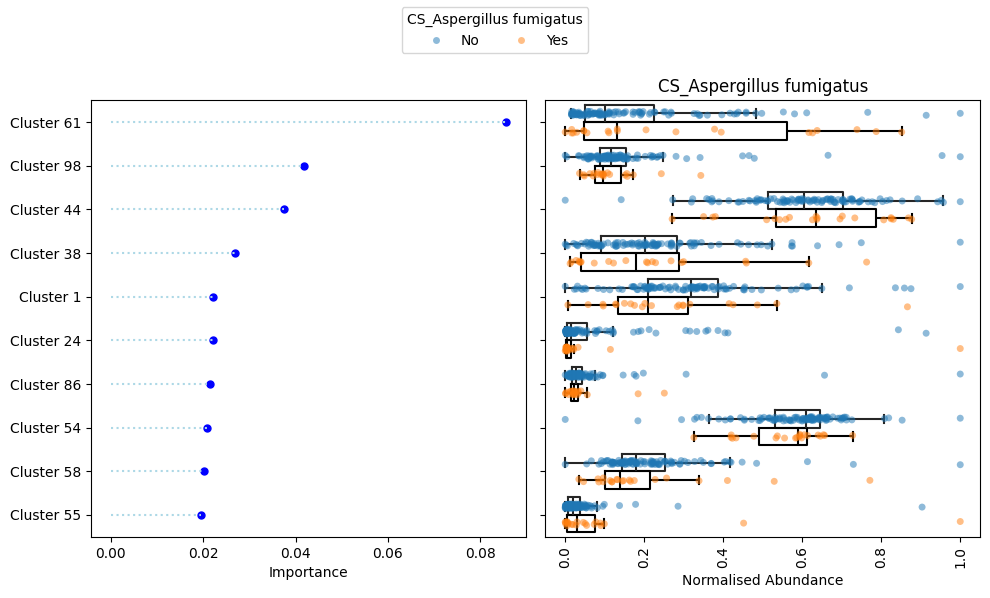

In [20]:
intcol = 'CS_Aspergillus fumigatus'
print(f"'{intcol}' has samples from {metadata.groupby(intcol).size()[1]} pwCF")

# ignore adjustText warnings in this block
warnings.filterwarnings("ignore", category=UserWarning, module='adjustText')

replace_index = re.compile(r'^\d+\s+')
replace_nonword = re.compile(r'\W+')


n_estimators=1000

# set up our titles and the filename
intcol_title = replace_index.sub('', intcol)
intcol_filename = intcol.replace(" ", "_")

merged_df = pc_df.join(metadata[[intcol]]).dropna(subset=intcol)

# do we need to encode this column
custom_labels = {0: 'No', 1: 'Yes'}
categorical_data = False
if pd.api.types.is_numeric_dtype(metadata[intcol]):
    # this is an numeric column, so we can just continue
    categorical_data = False
elif isinstance(metadata[intcol].dtype, pd.CategoricalDtype) and pd.api.types.is_numeric_dtype(metadata[intcol].cat.categories.dtype):
    # this is a categorical column with numeric categories so we can also continue
    categorical_data = True
elif isinstance(merged_df[intcol].dtype, pd.CategoricalDtype):
    # this is a categorical column with string categories so we need to encode it
    enc = OrdinalEncoder()
    metadata_encoder = enc.fit(merged_df[[intcol]])
    categories = metadata_encoder.categories_[0]
    custom_labels = {code: cat for code, cat in enumerate(categories)}
    merged_df[intcol] = metadata_encoder.transform(merged_df[[intcol]])
    categorical_data = True
else:
    # not sure what this is, so we skip it for now
    print(f"Error: {intcol} is not a numeric or categorical column. Skipped", file=sys.stderr)


X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]


met = None

if categorical_data or metadata[intcol].dtype == 'object':
    mse, feature_importances_sorted = cf_analysis_lib.gb_classifier(X, y, n_estimators)
    met = 'classifier'
else:
    mse, feature_importances_sorted = cf_analysis_lib.gb_regressor(X, y, n_estimators)
    met = 'regressor'


print(f"Mean squared error for {intcol} using {met} is {mse}", file=sys.stderr)

    
y_features = 10

topN = list(feature_importances_sorted[:y_features].index) + [intcol]
fig, axes = plt.subplots(figsize=(10, 6), nrows=1, ncols=2, sharey='row', sharex='col')
cf_analysis_lib.plot_feature_importance(axes[0], feature_importances_sorted[:y_features][::-1], "")
cf_analysis_lib.plot_feature_abundance(axes[1], merged_df[topN][::-1], intcol, intcol_title)


handles, labels = axes[1].get_legend_handles_labels()  # Get one set of handles and labels
updated_labels = labels
try:
    updated_labels = [custom_labels[float(label)] for label in labels]
except Exception as e:
    print(f"Couldn't use float for labels {e}.", file=sys.stderr)

for ax in axes.flat:
    if ax.get_legend() is not None:  # Check if legend exists
        ax.get_legend().remove()

plt.xticks(rotation=90)
fig.legend(handles, updated_labels, loc='upper center', ncol=2, title=intcol_title)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


# Print some information about an interesting cluster or column

# Manually make an image. 

Note that this recreates the images we make automatically, but allows you to tweak things. It saves them to a new location!

'CS_Aspergillus fumigatus' has samples from 22 pwCF


Wrote the new image to cluster_gbrfs_mags/img/clusters_manual/CS_Aspergillus_fumigatus_Cluster_71.png


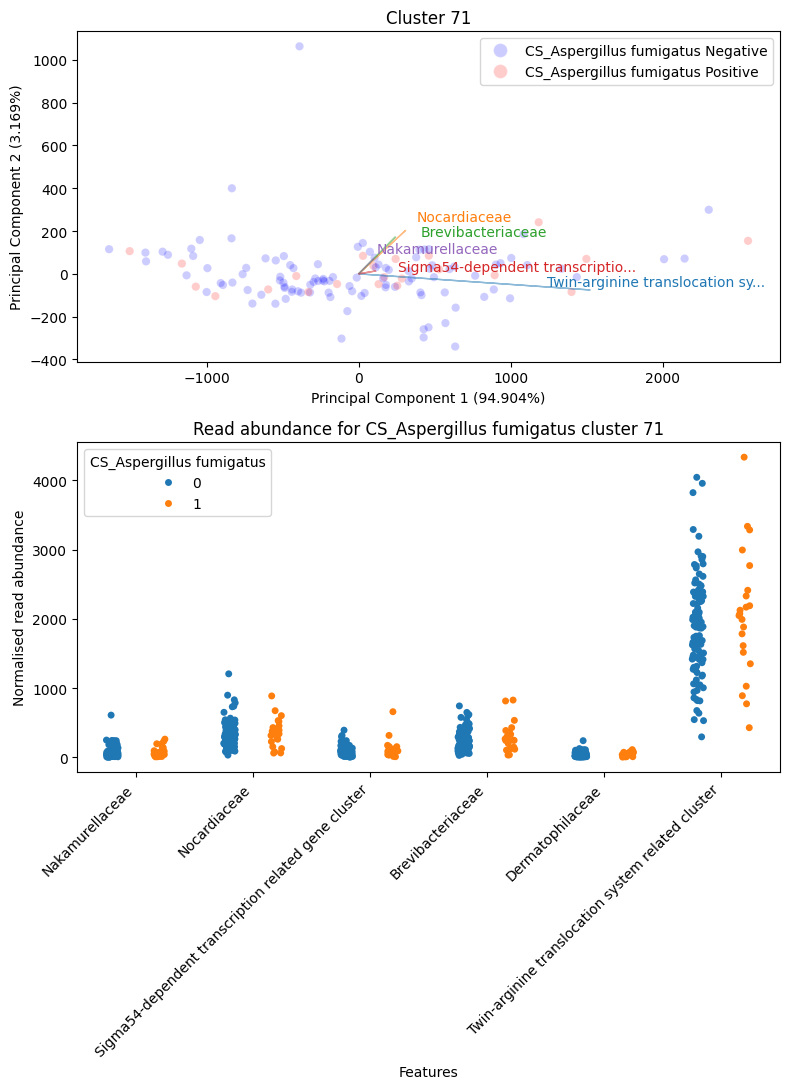

In [21]:
intcol = 'CS_Aspergillus fumigatus'
interesting_cluster = 71
print(f"'{intcol}' has samples from {metadata.groupby(intcol).size()[1]} pwCF")

if isinstance(interesting_cluster, int):
    interesting_cluster_filename = f"Cluster_{interesting_cluster}"
elif 'Cluster' in interesting_cluster:
    interesting_cluster_filename = interesting_cluster.replace(" ", "_")
else:
    interesting_cluster_filename = f"Cluster_{interesting_cluster}"
intcol_filename = intcol.replace(" ", "_")
intcol_filename = replace_nonword.sub('', intcol_filename)


# make a new dir so we don't overwrite!
os.makedirs(os.path.join(outdir, "img", "clusters_manual"), exist_ok=True)

pca = PCA(n_components=2)
int_cluster_num = interesting_cluster

df_clust = df[cluster_assignments.loc[cluster_assignments["Cluster"] == int_cluster_num, "Feature"]]
merged_df_clust = df_clust.join(metadata[[intcol]])

if intcol == 'CFLD':
    mask = merged_df_clust[intcol].notna() & (merged_df_clust[intcol] != 'Unknown')
    merged_df_clust = merged_df_clust[mask]
    merged_df_clust[intcol] = merged_df_clust[intcol].cat.remove_unused_categories()
    df_clust = merged_df_clust.drop(intcol, axis=1)

pca_result = pca.fit_transform(df_clust)
pca_df = pd.DataFrame(data=pca_result, index=df_clust.index, columns=['PC1', 'PC2'])

# Get loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(loadings, index=df_clust.columns, columns=['PC1', 'PC2'])

# Create a DataFrame for top loadings
top_loadings_df = loadings_df.loc[loadings_df['PC1'].abs().sort_values(ascending=False).index]
top_loadings_df.head()

explained_variance = pca.explained_variance_ratio_ * 100
pc1_variance = explained_variance[0]
pc2_variance = explained_variance[1]

# don't forget to change the legend
intcol_neg = 0

colours = np.where(merged_df_clust[intcol] == intcol_neg, 'blue', 'red')

# Plot the PCA results
fig, axes = plt.subplots(figsize=(8, 11), nrows=2, ncols=1)
ax = axes[0]
sns.scatterplot(data=pca_df, x='PC1', y='PC2', alpha=0.2, c=colours, ax=ax)
ax.set_title(f"Cluster {interesting_cluster}")
ax.set_xlabel(f'Principal Component 1 ({pc1_variance:.3f}%)')
ax.set_ylabel(f'Principal Component 2 ({pc2_variance:.3f}%)')

# add the loadings ... we only plot maxloadings here
maxloadings = 5
if len(loadings) < maxloadings:
    maxloadings = len(loadings)

plotscaler = 2
texts = []
colour_cycle = cycle(mcolors.TABLEAU_COLORS)


for i in range(maxloadings):
    c = next(colour_cycle)
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    ax.arrow(0, 0, xpos, ypos, 
              color=c, alpha=0.5, width=0.05)
    loading_text = top_loadings_df.index[i]
    if len(loading_text) > 30:
        loading_text = loading_text[:30] + "..."
    texts.append(ax.text(xpos, ypos, loading_text, color=c))

adjust_text(texts, ax=ax)

# Add a legend
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label=f'{intcol} Negative', 
                         markerfacecolor='blue', alpha=0.2, markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label=f'{intcol} Positive', 
                        markerfacecolor='red', alpha=0.2, markersize=10)
ax.legend(handles=[blue_patch, red_patch])

## Read abundance
ax = axes[1]

df_clust_m = merged_df_clust.melt(id_vars=intcol, var_name='Features', value_name='Normalised read abundance')
df_clust_m = df_clust_m[df_clust_m['Normalised read abundance'] > 0]

cl = {'IP': 'red', 'OP': 'blue'}
sns.stripplot(data=df_clust_m, x='Features', y='Normalised read abundance', hue=intcol, dodge=True, jitter=True, ax=ax)

ax.tick_params(axis='x', rotation=45)
for label in ax.get_xticklabels():
    label.set_horizontalalignment('right')
ax.set_title(f"Read abundance for {intcol} cluster {interesting_cluster}")


plt.tight_layout()
plt.savefig(os.path.join(outdir, "img", "clusters_manual", f"{intcol_filename}_{interesting_cluster_filename}.png"))
print(f'Wrote the new image to {os.path.join(outdir, "img", "clusters_manual", f"{intcol_filename}_{interesting_cluster_filename}.png")}', file=sys.stderr)
# Show the plot
plt.show()

# Plot some non-categorical data!

Some of our data is continuous. Eeek

### Plot using the PCA data

TypeError: Categorical is not ordered for operation min
you can use .as_ordered() to change the Categorical to an ordered one


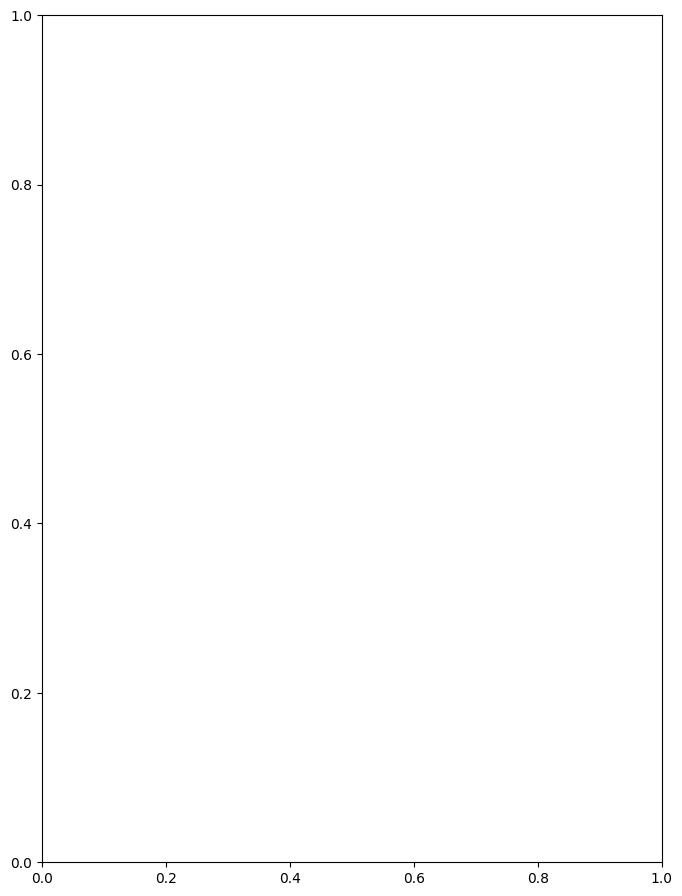

In [22]:
meta_pca = metadata[[intcol]].join(pca_df[['PC1']])
plt.subplots(figsize=(8, 11))
ax = sns.regplot(data=meta_pca, x=intcol, y='PC1',
    scatter=True,         # Plot the scatter points
    fit_reg=True,         # Fit and plot the regression line
    ci=95,                # Shaded 95% confidence interval
    scatter_kws={'color': 'blue', 'alpha': 0.2},  # Customize scatter points
    line_kws={'color': 'red'}  # Customize regression line
)

ax.set_title(f"Read abundance for {intcol} cluster {interesting_cluster}")
plt.tight_layout()

plt.savefig(os.path.join(outdir, "img", "clusters_manual", f"{intcol_filename}_{interesting_cluster_filename}_regplot.png"))
print(f'Wrote the new image to {os.path.join(outdir, "img", "clusters_manual", f"{intcol_filename}_{interesting_cluster_filename}_regplot.png")}', file=sys.stderr)
# Show the plot
plt.show()
